# Проект для «Викишоп» c BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
%%capture
!pip3 install -U spacy
!pip3 install -U spacy-lookups-data
!python -m spacy download en

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [41]:
# импортируем необходимые библиотеки для работы с данным
import pandas as pd
import numpy as np
import random

# библиотки для работы с текстом
import re
from nltk.corpus import stopwords 
import spacy
import en_core_web_sm
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from concurrent.futures import ProcessPoolExecutor

import nltk
nltk.download('stopwords') 
nltk.download('wordnet')

# подготовка данных для моделирование
import torch
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import transformers
from transformers import BertTokenizer

# модели
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from catboost import CatBoostClassifier

# метрики
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score


# визуализация
import matplotlib.pyplot as plt
from tqdm import tqdm

random.seed(42)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Grine\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Grine\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Загрузка и EDA

In [4]:
df = pd.read_csv(r'C:\Users\Grine\Desktop\toxic_comments.csv', index_col='Unnamed: 0')
#df = pd.read_csv('/datasets/toxic_comments.csvv', index_col='Unnamed: 0')

*Сразу проверим пропуски и типы*

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [6]:
df.sort_values(by='text').head(5)

,text,toxic
119123,"""""""",1
136036,"wikipedia-watch.org ALL TRUE 100% LOL!!!""",0
93328,!\n\nI won't stop! LOCK IT UP A$$HOLE,1
124432,"!\n\nIt is now inside your bones, your head. H...",1
9296,!\n\nSuck my DIHCK! Nihgga!\n\nYou don't want ...,1


*В данных есть выбросы. Необходимо избавиться от них. Попробуем очистить данные с помощь regex*

In [7]:
# теперь инциализируем функцию, которая будет предобрабтывать и лематизировать текст
def clean_text(text: str) -> str:
    '''
    Функция избавляет текст от лишних символов
    '''
    
    # очистка
    text = text.lower()
    text_clean = re.sub(r'[^a-zA-Z]', ' ', text)
    splited_clean_text = text_clean.split()
    text_clean = ' '.join(splited_clean_text)
    
    # результат
    return text_clean

In [8]:
df['text'] = df.text.apply(lambda x: clean_text(x))

*Для эффективной очистки посчитаем кол-во слов*

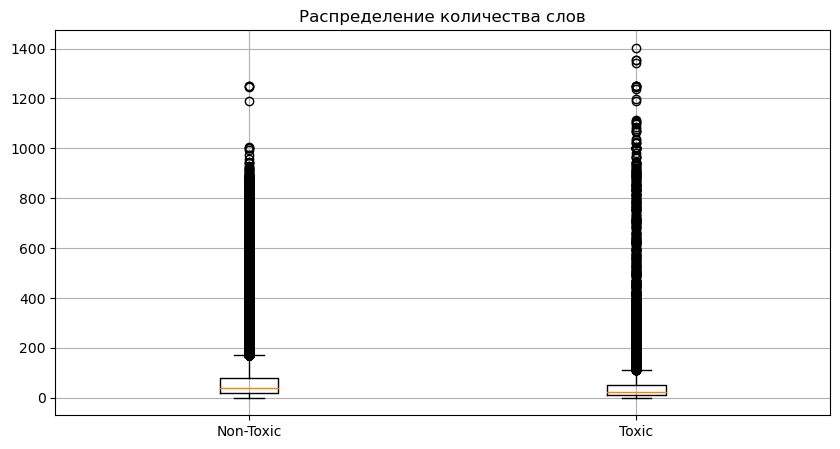


 Описательная статистика признака "word_count":


count    159292.000000
mean         68.072182
std         100.838005
min           0.000000
25%          17.000000
50%          36.000000
75%          76.000000
max        1403.000000
Name: word_count, dtype: float64

In [9]:
df['word_count'] = [len(t.split()) for t in df['text']]
plt.figure(figsize=(10, 5))
ax = plt.gca()

positions = [0, 1]
ax.boxplot([df[df['toxic'] == 0]['word_count'], df[df['toxic'] == 1]['word_count']], positions=positions)

ax.set_xticks(positions)
ax.set_xticklabels(['Non-Toxic', 'Toxic'])
plt.grid(True)
plt.title('Распределение количества слов')
plt.show()

print('\n Описательная статистика признака "word_count":')
df['word_count'].describe()

*Видно, что в обоих классах существуют аномально выоские и аномально низкие значения. Можно очистить данные, оставив только те комменатрии, где больше 10 и меньше 100 слов.*

In [10]:
df = df[(df['word_count'] < 100) & (df['word_count'] > 10)]

In [11]:
print('Процент положительных классов:', round(df['toxic'].sum()/len(df['toxic'])*100, 1))

Процент положительных классов: 9.9


*10% объектов клаcса положительные. Стоит помнить об этом, при моделирование! Бороться с дисбалансом в данной задаче не надо.*

### Подготовка данных TF-IDF

In [29]:
%%time
# Загружаем языковую модель для английского языка
nlp = spacy.load("en_core_web_sm")

# Функция для лемматизации текста с использованием SpaCy
def lemmatize_with_spacy(text):
    doc = nlp(text)
    lemmatized_words = [token.lemma_ for token in doc]
    return ' '.join(lemmatized_words)

df['lemmas'] = df.text.apply(lambda x: lemmatize_with_spacy(x))

Wall time: 6min 58s


In [30]:
# подготовим данные без берта
X_train, X_test, y_train, y_test = train_test_split(df['lemmas'], df.toxic,
                                                    stratify=df.toxic, # поскольку есть явный дисбаланс классов
                                                    shuffle=True,
                                                    train_size=0.8,
                                                    random_state=42)

stop_words = set(stopwords.words('english'))

# Инициализация TfidfVectorizer с использованием списка стоп-слов
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words)

# Преобразование текста в TF-IDF матрицу
X_train = tfidf_vectorizer.fit_transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)

print("Размер матрицы:", X_train.shape)

Размер матрицы: (85678, 79600)


**Данные подготовлены для базового моделирования!**

### Подготовка данных BERT

*Для берт такой объём данных - слишком большой. Поэтому мы возьмём только 10.000 положительных, и, 10.000 отрциательных комментариев*

In [64]:
df_bert = pd.concat([df[df.toxic == 0].sample(1000, random_state=42).reset_index(drop=True),
                     df[df.toxic == 1].sample(1000, random_state=42).reset_index(drop=True)])[['text', 'toxic']]

*Инциализируем токенайзер и применим к нашему тексту*

In [65]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenized = df_bert['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True))

*Найдём максимальную длину последоватльности (комментариев) и п преобразуем необходимым образом наш исходный массив*

In [34]:
max_len = 512
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
        
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

In [35]:
# инициализируем нашу берт модель
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [36]:
batch_size = 100
embeddings = []
for i in tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [11:09<00:00, 33.49s/it]


In [37]:
# создадим набор признаков
features = np.concatenate(embeddings)

## Обучение

**Линейная регрессия**

In [46]:
log_reg_params = {
    'penalty': ['l1', 'l2', None],
    'C': range(5, 15)
}

model = LogisticRegression()
grid = GridSearchCV(model, log_reg_params, scoring='f1', cv=3, n_jobs=-1)

grid.fit(X_train, y_train)

print('Результаты линейной регрессии:', round(grid.best_score_, 2))

Результаты линейной регрессии: 0.75


*Результаты на валидацию дают целевое значение заявленное в требование заказчика. Протестируем:*

In [53]:
best_log_reg = grid.best_estimator_
best_log_reg.fit(X_train, y_train)

print('f1 метрика на тесте:', round(f1_score(best_log_reg.predict(X_test), y_test), 2))

f1 метрика на тесте: 0.77


*Логистическая регрессия с выбранной предобработкой даёт целевой результат. Тем не менее, попробуем улучшить метрику, используя BERT-предобработку.*

### Линейная регрессия, с BERT.

In [55]:
# подготовим данные без берта
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(features, df_bert.toxic,
                                                    stratify=df_bert.toxic, # поскольку есть явный дисбаланс классов
                                                    shuffle=True,
                                                    train_size=0.8,
                                                    random_state=42)

In [56]:
log_reg_params = {
    'penalty': ['l1', 'l2', None],
    'C': range(5, 15)
}

model = LogisticRegression()
grid = GridSearchCV(model, log_reg_params, scoring='f1', cv=3, n_jobs=-1)

grid.fit(X_train_bert, y_train_bert)

print('Результаты линейной регрессии BERT:', round(grid.best_score_, 2))

Результаты линейной регрессии BERT: 0.86


In [60]:
best_log_reg = grid.best_estimator_
best_log_reg.fit(X_train_bert, y_train_bert)

preds = best_log_reg.predict(X_test_bert)
print('f1 метрика на тесте BERT:', round(f1_score(preds, y_test_bert), 2))

f1 метрика на тесте BERT: 0.87


*Результаты соотвествует ожидаемому требованию. Построим матрицу ошибок:*

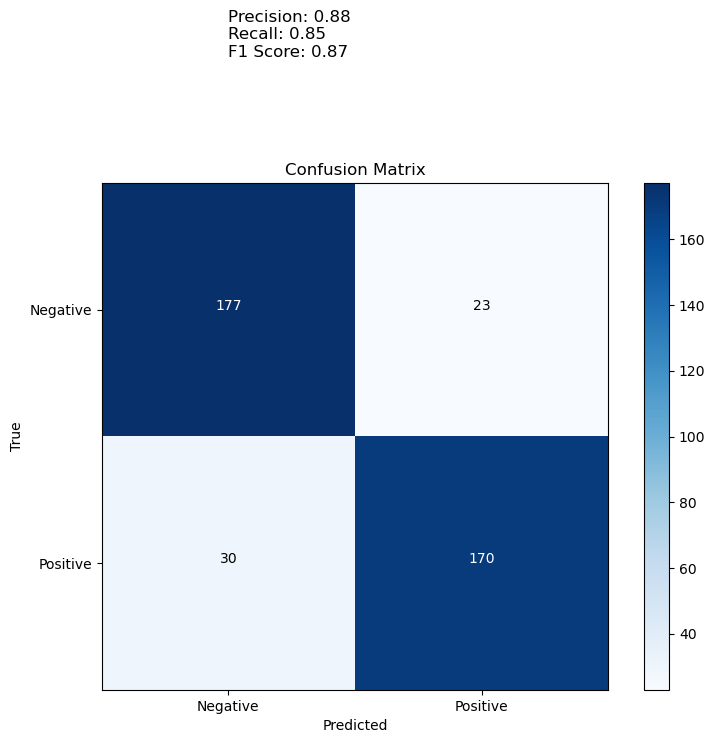

In [61]:
# Рассчитываем матрицу ошибок, полноту, точность и F1-меру
conf_matrix = confusion_matrix(y_test_bert, preds)
precision = precision_score(y_test_bert, preds)
recall = recall_score(y_test_bert, preds)
f1 = f1_score(y_test_bert, preds)

# Создаем график матрицы ошибок
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

classes = ["Negative", "Positive"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

# Добавляем значения в ячейки матрицы
thresh = conf_matrix.max() / 2.0
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()

# Выводим метрики (полноту, точность, F1-меру) на графике
metrics_text = f'Precision: {precision:.2f}\nRecall: {recall:.2f}\nF1 Score: {f1:.2f}'
plt.text(0, -1, metrics_text, fontsize=12)

plt.show()

## Выводы

В результате проведённого исследования, была создана модель, которое потребовалось всего 2.000 наблюдений для достижения целевой метрики f1-score. 

Важно, что модель работает с учётом дисбалансов классов, модель сбалансирована, как с точки зрения полноты, так, и, с точки зрения плотности. 

Результаты соответствуют значению f1-score - 0.87. Такая модель должна эффективно справляться с задачей классификации вредоносных комментариев. Тем не менее, у модели есть потенциал для роста, мы можем использовать большую выборку для обучения.